explore data and prepare for model building

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data = train_data.dropna()

train_data = pd.get_dummies(train_data, columns=['parentspecies'])

scaler = StandardScaler()
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data[numeric_columns] = scaler.fit_transform(train_data[numeric_columns])

print(train_data.head())

         ID  log_pSat_Pa        MW  NumOfAtoms    NumOfC    NumOfO    NumOfN  \
0 -1.732855    -1.852422 -0.821253   -0.625586 -0.593455 -0.378290 -1.500663   
1 -1.732745     0.233035  0.912392    1.666040  1.464262  0.023877  1.314858   
2 -1.732636    -0.222260  2.080320    2.047978  2.150168  1.230377  1.314858   
3 -1.732526    -1.332871  0.689715    0.520227  0.092451  0.828210 -0.092903   
4 -1.732417     0.402894 -1.264607   -1.198493  0.092451 -1.182623 -1.500663   

   NumHBondDonors  NumOfConf  NumOfConfUsed  ...  hydroperoxide  \
0        1.762932   1.251126       0.969956  ...       1.763400   
1       -1.173103   0.026537       0.969956  ...       0.328098   
2       -1.173103   0.380635       0.969956  ...       0.328098   
3        1.762932   2.647846      -1.552772  ...       0.328098   
4       -1.173103  -0.755429       0.424501  ...       0.328098   

   carbonylperoxyacid  nitroester  parentspecies_apin  \
0           -0.557176   -0.113512               False   
1 

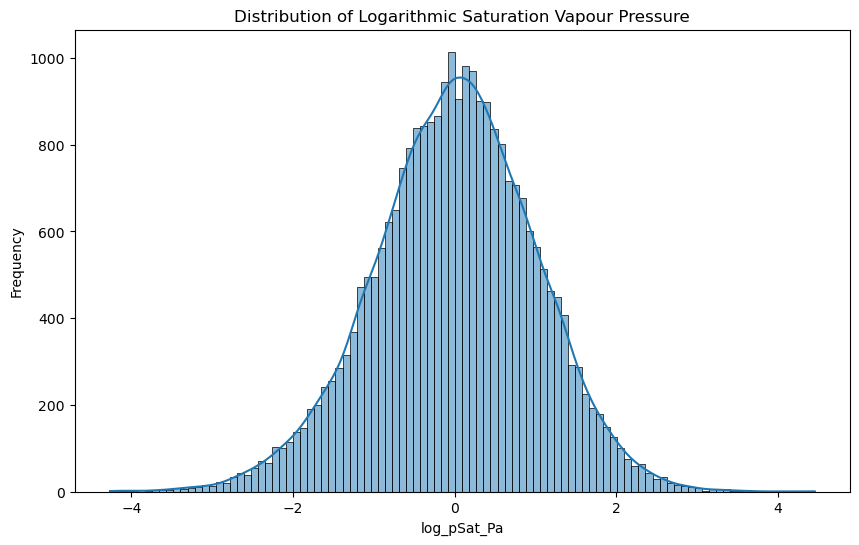

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train_data['log_pSat_Pa'], kde=True)
plt.title('Distribution of Logarithmic Saturation Vapour Pressure')
plt.xlabel('log_pSat_Pa')
plt.ylabel('Frequency')
plt.show()

log_pSat_Pa is the target variable we are trying to predict

distribution is highly skewed, we might consider using models that can handle skewed data or applying transformations

peak shows median

width is range

no outliers

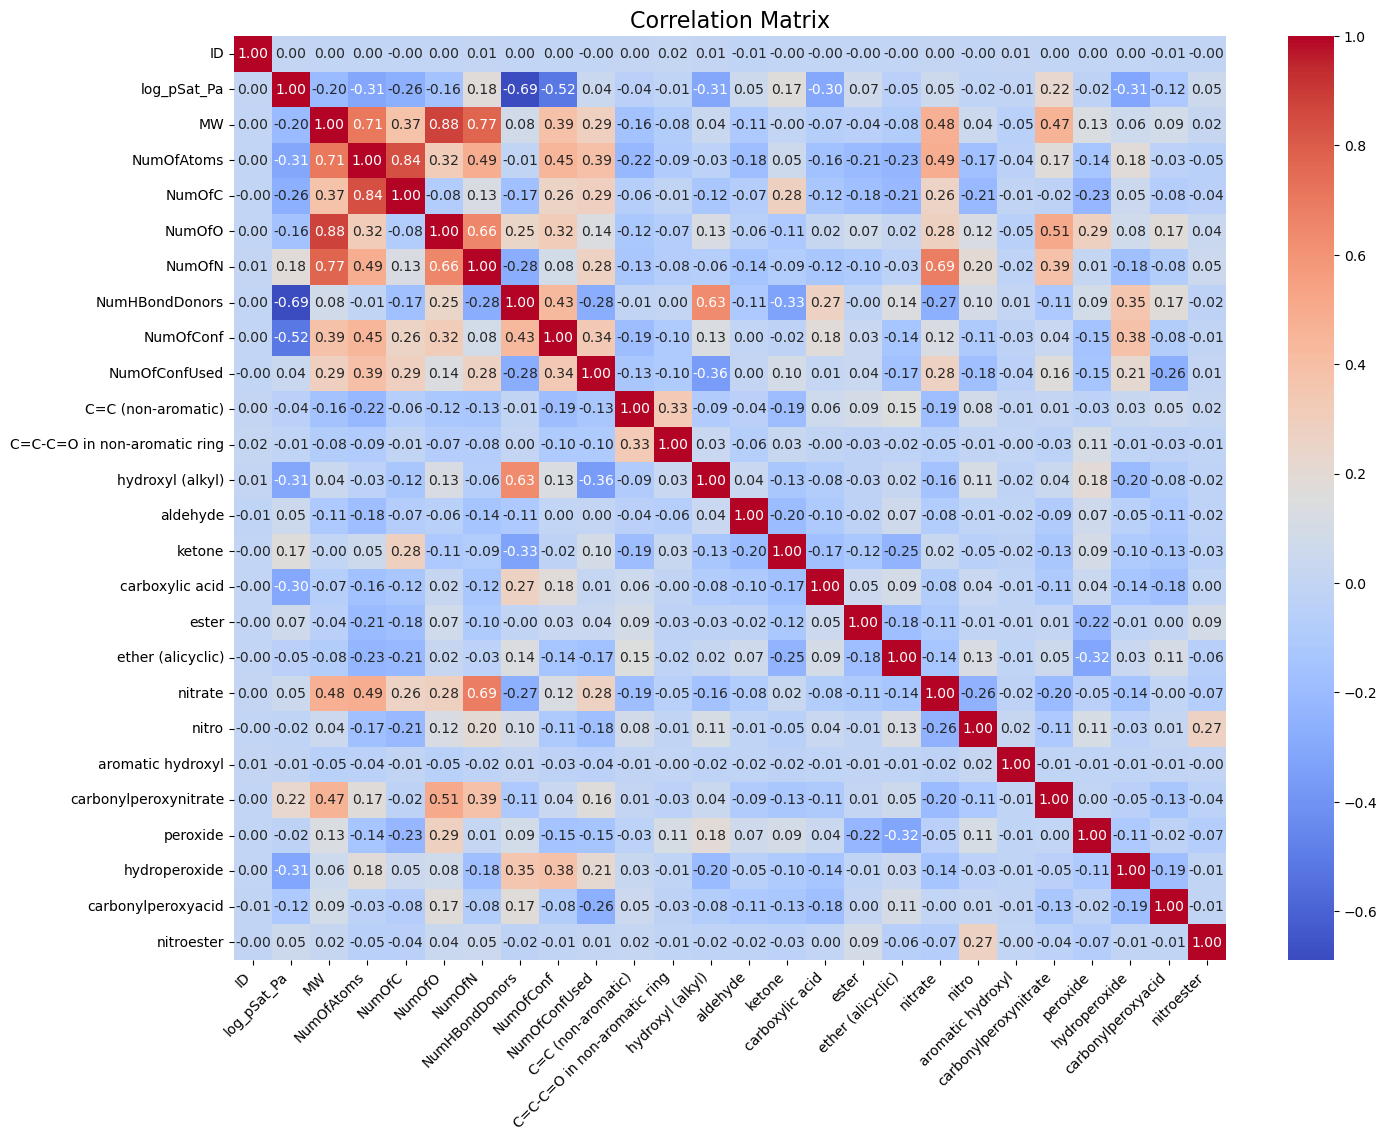

In [4]:
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
correlation_matrix = train_data[numeric_columns].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

High Positive Correlation: Indicates that as one feature increases, the other feature also increases.
High Negative Correlation: Indicates that as one feature increases, the other feature decreases.
Low or No Correlation: Indicates little to no linear relationship between the features.

identify linear relationships

Strong correlations (positive or negative) indicate that one feature can be predicted from another.

High correlations can show multicollinearity

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint as sp_randint

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

features = ['MW', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN', 'NumHBondDonors', 'NumOfConf', 'NumOfConfUsed', 'C=C (non-aromatic)', 'C=C-C=O in non-aromatic ring', 'hydroxyl (alkyl)', 'aldehyde', 'ketone', 'carboxylic acid', 'ester', 'ether (alicyclic)', 'nitrate', 'nitro', 'aromatic hydroxyl', 'carbonylperoxynitrate', 'peroxide', 'hydroperoxide', 'carbonylperoxyacid', 'nitroester']
categorical_features = ['parentspecies']
target = 'log_pSat_Pa'

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

X = train_df[features + categorical_features]
y = train_df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'regressor__n_estimators': sp_randint(50, 200),
    'regressor__max_depth': sp_randint(3, 10),
    'regressor__min_samples_split': sp_randint(2, 11),
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2]
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)
print(f'R2 Score: {r2_score(y_val, y_pred)}')
print(f'Mean Squared Error: {mean_squared_error(y_val, y_pred)}')

X_test = test_df[features + categorical_features]
test_predictions = best_model.predict(X_test)

submission = pd.DataFrame({
    'ID': test_df['ID'],
    'TARGET': test_predictions
})

submission['TARGET'] = submission['TARGET'].round(9)

submission.to_csv('submission.csv', index=False)

R2 Score: 0.743681247974149
Mean Squared Error: 2.499770373820834


(dc1 5-6) the datasets are loaded into pandas dataframes.

(dc1 8) data is cleaned by dropping rows with missing values. Another method was to fill the NaN values with the mean or mode but it gave worse results because it likely introduced noise or bias.

(dc1 10) Categorical variables are encoded using one-hot encoding.

(dc1 12-14) Numerical features are standardized using StandardScaler:


(dc2 4-9) The distribution of the target variable (log_pSat_Pa) is visualized using a histogram with a kernel density estimate (KDE): This visualization helps understand the distribution of the target variable, which is crucial for selecting appropriate models and preprocessing steps.

(dc3 1-7) The correlation matrix of the numerical features is computed and visualized using a heatmap: The correlation matrix helps identify linear relationships between features, which can inform feature selection and model building.


(dc4 16-18) The features and target variable are defined:

(dc4 20-32) Preprocessing pipelines for numerical and categorical features are defined:

(dc4 34-37) A pipeline is created to preprocess the data and then apply a Gradient Boosting Regressor:

(dc4 39-41) The data is split into training and validation sets:

(dc4 43-51) Hyperparameter tuning is performed using RandomizedSearchCV:

from 43 to 51, hyperparameter tuning with randomizedsearchcv is used.

from 43 to 48, the dictionary param_dist is used for the hypermarameter ranges to tune

regressor__n_estimators: Number of boosting stages (trees) to be run. The range is between 50 and 200, because, few trees result in underfitting and too many trees result in overfitting.
regressor__max_depth: Maximum depth of the individual regression estimators. The range is between 3 and 10, because, shallow trees (low depth) captures simple patterns and deeper trees capture complex patterns.
regressor__min_samples_split: Minimum number of samples required to split an internal node. The range is between 2 and 11, because higher values prevent the model from learning overly specific patterns (overfitting).
regressor__learning_rate: Learning rate shrinks the contribution of each tree by the specified value. The possible values are 0.01, 0.05, 0.1, and 0.2 because lower values make the model learn more slowly and leads to better generalization.

trial-error, intuition, and use of internet sources general consensus are used for these parameters. These values are used as a starting piont for hyperparameter tuning in Gradient Boosting models. It gives flexibility to the data to capture patterns without being too restrictive.


(dc4 53-56) The best model is selected, and its performance is evaluated on the validation set:

(dc4 58-59) Predictions are made on the test set and a subbmission file is created with them:


Summary
This Jupyter Notebook provides a comprehensive workflow for data exploration, preprocessing, model building, and evaluation. It starts with loading and cleaning the data, followed by visualizing the distribution of the target variable and the correlation matrix of the features. The notebook then defines preprocessing pipelines for numerical and categorical features, builds a Gradient Boosting Regressor model, and performs hyperparameter tuning using RandomizedSearchCV. Finally, the model is evaluated on a validation set, and predictions are made on the test set, which are saved in a submission file. This structured approach ensures that the data is properly prepared and the model is optimized for the best performance.

## for the report

1. The stages of your data analysis, including how you looked at the data to understand it (visualisations,
unsupervised learning methods, etc.).

The first step in the data analysis process was to load the datasets into pandas DataFrames. This was done using the pd.read_csv function for both the training and test datasets.

Next, the data was cleaned by dropping rows with missing values. This decision was made because filling the NaN values with the mean or mode introduced noise or bias, leading to worse results.

Categorical variables were encoded using one-hot encoding. This was done using the pd.get_dummies function, which converts categorical variables into dummy/indicator variables.

Numerical features were standardized using StandardScaler from sklearn.preprocessing. This step ensures that the numerical features have a mean of 0 and a standard deviation of 1, which is important for many machine learning algorithms.

The distribution of the target variable (log_pSat_Pa) was visualized using a histogram with a kernel density estimate (KDE). This visualization helps understand the distribution of the target variable, which is crucial for selecting appropriate models and preprocessing steps.

The correlation matrix of the numerical features was computed and visualized using a heatmap. The correlation matrix helps identify linear relationships between features, which can inform feature selection and model building.

2.  Description of considered machine learning approaches and pros and cons of the chosen approach for
this application.

Several machine learning approaches were considered for this regression task, including:

Linear Regression: Simple and interpretable but may not capture complex relationships.
Decision Trees: Can capture non-linear relationships but prone to overfitting.
Random Forest: Ensemble method that reduces overfitting but can be computationally expensive.
Gradient Boosting: Ensemble method that builds trees sequentially to correct errors of previous trees.

The chosen approach for this application was the Gradient Boosting Regressor. The reasons for this choice include:

Pros:

    Can capture complex non-linear relationships.

    Reduces overfitting through boosting.

    Provides good predictive performance.

Cons:
    Computationally expensive.
    
    Requires careful tuning of hyperparameters.

3. Steps you took to select good features and model parameters.

The features and target variable were defined based on domain knowledge and the initial data exploration. The selected features included various molecular properties and counts of different types of atoms and bonds.

Hyperparameter tuning was performed using RandomizedSearchCV to find the best combination of hyperparameters for the Gradient Boosting Regressor. The parameter ranges were chosen based on common practices and guidelines for tuning Gradient Boosting models.

4.  Summary of your results, insights learned, and how the regression model performed.

The best model was selected based on the cross-validation results, and its performance was evaluated on the validation set using the R-squared and Mean Squared Error metrics.

Predictions were made on the test set, and a submission file was created with the predicted values.

This Jupyter Notebook provides a comprehensive workflow for data exploration, preprocessing, model building, and evaluation. It starts with loading and cleaning the data, followed by visualizing the distribution of the target variable and the correlation matrix of the features. The notebook then defines preprocessing pipelines for numerical and categorical features, builds a Gradient Boosting Regressor model, and performs hyperparameter tuning using RandomizedSearchCV. Finally, the model is evaluated on a validation set, and predictions are made on the test set, which are saved in a submission file. This structured approach ensures that the data is properly prepared and the model is optimized for the best performance.